In [ ]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll

### Download into file

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [ ]:
folder = 'earth'
file = 'urls_earth.csv'

In [ ]:
folder = 'jupiter'
file = 'urls_jupiter.csv'

In [ ]:
folder = 'saturn'
file = 'urls_saturn.csv'

In [ ]:
folder = 'mars'
file = 'urls_mars.csv'

You will need to run this cell once per each category.

In [ ]:
path = Path('data/planets')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

[PosixPath('data/planets/urls_saturn.csv'),
 PosixPath('data/planets/saturn'),
 PosixPath('data/planets/urls_earth.csv'),
 PosixPath('data/planets/jupiter'),
 PosixPath('data/planets/urls_jupiter.csv'),
 PosixPath('data/planets/earth'),
 PosixPath('data/planets/mars')]

## Download images

In [ ]:
classes = ['earth','jupiter','saturn', 'mars']

In [ ]:
download_images(path/file, dest, max_pics=200)

Error https://hdwallpaperim.com/wp-content/uploads/2017/08/23/468661-Mars-planet-Solar_System-space-748x421.jpg HTTPSConnectionPool(host='hdwallpaperim.com', port=443): Read timed out. (read timeout=4)
Error https://img.futurezone.de/img/science/crop228498251/7544582792-w1200-cv3_2-q70/Planet-Mars.jpg HTTPSConnectionPool(host='img.futurezone.de', port=443): Read timed out. (read timeout=4)


In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

FileNotFoundError: ignored

Then we can remove any images that can't be opened:

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

earth


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


jupiter


cannot identify image file <_io.BufferedReader name='data/planets/jupiter/00000003.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


saturn


mars


cannot identify image file <_io.BufferedReader name='data/planets/mars/00000074.jpg'>
cannot identify image file <_io.BufferedReader name='data/planets/mars/00000072.jpg'>
cannot identify image file <_io.BufferedReader name='data/planets/mars/00000151.jpg'>


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:987: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


## View data

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [ ]:
data.classes

['earth', 'jupiter', 'mars', 'saturn']

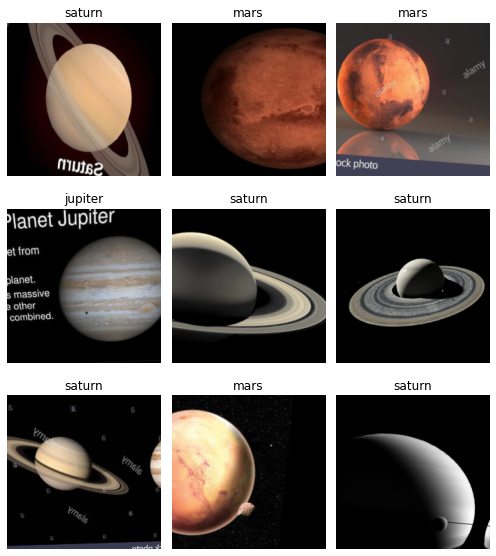

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['earth', 'jupiter', 'mars', 'saturn'], 4, 601, 150)

## Train model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.409516,0.736590,0.186667,03:27
1,0.903878,0.740251,0.166667,03:24
2,0.661005,0.674096,0.146667,03:24
3,0.565907,0.657552,0.153333,03:28


In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
# If the plot is not showing try to give a start and end learning rate
 learn.lr_find(start_lr=1e-5, end_lr=1e-1)
#learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


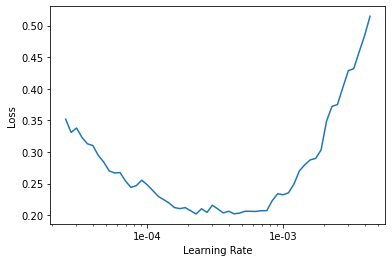

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.391378,0.869058,0.173333,04:54
1,0.355306,0.817695,0.206667,04:54


In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-1');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

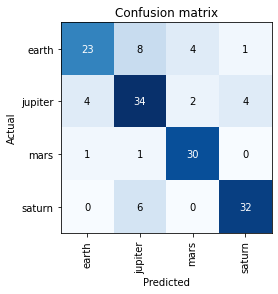

In [ ]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :)'

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [ ]:
learn.export()

In [ ]:
defaults.device = torch.device('cpu')

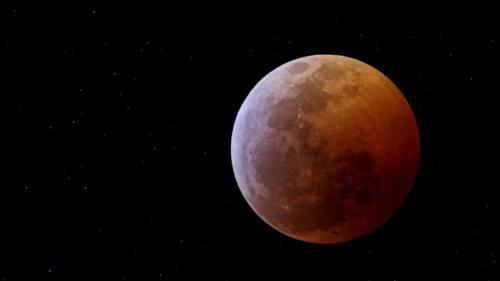

In [ ]:
img = open_image(path/'mars'/'00000066.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [ ]:
learn = load_learner(path)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category mars